# Computer Vision CSCI-GA.2272-001 Assignment 1, part 1.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction

This assignment is an introduction to using PyTorch for training simple neural net models. Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

You should perform this assignment in PyTorch by modifying this ipython notebook (File-->Save a copy...).

To install PyTorch, follow instructions at http://pytorch.org/

Please submit your assignment by uploading this iPython notebook to Brightspace.

## Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes
(airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

Use `matplotlib` and ipython notebook's visualization capabilities to display some of these images.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

**Relevant Cell: "Data Loading"**

## Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST.
By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The loss function [cross_entropy](http://pytorch.org/docs/master/nn.html?highlight=cross_entropy#torch.nn.functional.cross_entropy) computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given `target`.

**The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. 
Unless otherwise specified, use the default values throughout this assignment.**

Note the decrease in training loss and corresponding decrease in validation errors.

Paste the output into your report.
(a): Add code to plot out the network weights as images (one for each output, of size 28 by 28) after the last epoch. Grab a screenshot of the figure and include it in your report. (Hint threads: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) [#2](https://github.com/pytorch/vision#utils) )

(b): Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Training a Multi-Layer Network on MNIST [10%]

- Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class]. Train the model for 10 epochs and save the output into your report.
-  Now set the learning rate to 10 and observe what happens during training. Save the output in your report and give a brief explanation

## Training a Convolutional Network on CIFAR [25%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, 16 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Convolution with 5 by 5 filters, 128 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

Train it for 20 epochs on the CIFAR-10 training set and copy the output
into your report, along with a image of the first layer filters.

Hints: [Follow the first PyTorch tutorial](http://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) or look at the [MNIST example](https://github.com/pytorch/examples/tree/master/mnist). Also, you may find training is faster if you use a GPU runtime (RunTime-->Change Runtime Type-->GPU). 

- Give a breakdown of the parameters within the above model, and the overall number.

= = = = = = = = = = = = = = = = = = = = \
**Name:** Haoming(Hammond) Liu\
**NetID:** hl3797 \
= = = = = = = = = = = = = = = = = = = = \\

**Note:** The code has been properly organized, so you can run the whole notebook directly. Have a good day! :p

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01         # learning rate

# use cuda if it's available
use_cuda = torch.cuda.is_available()
device = ('cuda:0' if use_cuda else 'cpu')

# init network variables to avoid errors
single_net1 = None      # original version
single_net2 = None      # reduced-data version
multi_layer_net1 = None # original version
multi_layer_net2 = None # large-lr version
conv_net = None         # original version

In [ ]:
# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
print('Successfully initialized dataloaders for [%s].' % dataset)


Successfully initialized dataloaders for [mnist].


**\[Warmup - Plot the dataset\]** \\

Code Citation: \
1. Function `denormalize` originates from a [blog post](https://www.cnblogs.com/wanghui-garcia/p/11393076.html), and I modified it in my own [Github repo]( https://github.com/TeamOfProfGuo/SSeg/blob/final/masker.py).
2. The code for plotting is drawn from the [given tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py).


[Images]:


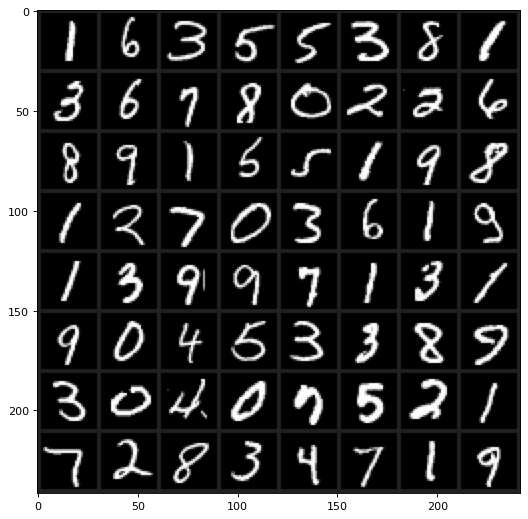

[Labels]:
tensor([[1, 6, 3, 5, 5, 3, 8, 1],
        [3, 6, 7, 8, 0, 2, 2, 6],
        [8, 9, 1, 5, 5, 1, 9, 8],
        [1, 2, 7, 0, 3, 6, 1, 9],
        [1, 3, 9, 9, 7, 1, 3, 1],
        [9, 0, 4, 5, 3, 3, 8, 9],
        [3, 0, 4, 0, 7, 5, 2, 1],
        [7, 2, 8, 3, 4, 7, 1, 9]])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# functions to denormalize an image
def denormalize(input_image, mean, std, imtype=np.uint8):
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data                     # only convert torch.Tensor
        else:
            return input_image
        image_numpy = image_tensor.float().numpy()              # convert it into a numpy array
        if image_numpy.shape[0] == 1:                           # expand grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)):                              # denormalize
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255                         # [0,1] to [0,255]
        image_numpy = np.transpose(image_numpy, (1, 2, 0))      # chw to hwc
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)

# functions to show an image
def imshow(batch_img):
    norm_params_dict = {
        'mnist': ((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)),
        'cifar10': ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    }
    mean, std = norm_params_dict[dataset]
    img = denormalize(make_grid(batch_img), mean, std)
    plt.figure(figsize=(8, 8), dpi=80)
    plt.imshow(img)
    plt.show()

# get some random training images (MNIST)
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('[Images]:')
imshow(images)
print('[Labels]:', labels.reshape(8, 8), sep='\n')

# Note: The CIFAR10 dataset is plotted in the second half of this notebook.

In [ ]:
# network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

In [ ]:
def train(network, epoch, dataloader):
    # Make sure the epoch num is valid
    assert network is not None
    assert isinstance(epoch, int) and epoch > 0

    if use_cuda:
        network = network.to(device)
        print('using cuda for training')

    network.train()
    for e in range(1, epoch+1):
        for batch_idx, (data, target) in enumerate(dataloader):
            if use_cuda:
                data, target = data.to(device), target.to(device)
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = network(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    e, batch_idx * len(data), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))

def test(network, dataloader, set_name='Test'):
    if use_cuda:
        network = network.to(device)
        print('using cuda for testing')
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader:
        #data, target = Variable(data, volatile=True), Variable(target)
        if use_cuda:
            data, target = data.to(device), target.to(device)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(dataloader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        set_name, test_loss, correct, len(dataloader.dataset),
        100. * correct / len(dataloader.dataset)))

**Training a Single Layer Network**

In [ ]:
# Start by initializing model and optimizer
print('\n====== init started ==========')
single_net1 = Net(num_inputs, num_outputs)
optimizer = optim.SGD(single_net1.parameters(), lr=lr)
print(single_net1)
print('init [Net] done')

# Train for 10 epochs (with default params setting)
print('\n====== training started ======')
train(single_net1, epoch=10, dataloader=train_loader)

print('\n====== testing started =======')
test(single_net1, dataloader=train_loader, set_name='Train')
test(single_net1, dataloader=test_loader, set_name='Test')


====== init started ==========
Net(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
init [Net] done

====== training started ======
using cuda for training
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.497993
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.828299
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.488177
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.409797
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.373361
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.472916
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.302117
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.296572
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.321742
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.236076
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.283634
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.369511
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.208608
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.290371
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.269217
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.480148
Train Epoch: 2 [38400/60000 (64%)]	Lo

**Plot the weights of the single-layer model (original version)**

[Weight Size]: torch.Size([10, 784])
[Grid Size]: torch.Size([3, 62, 152])


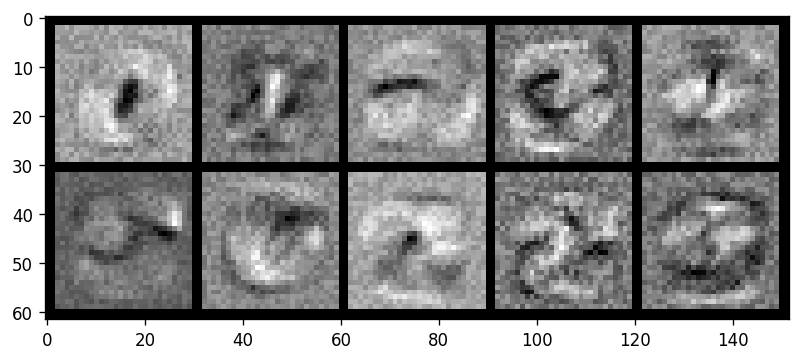

In [ ]:
from torchvision.utils import make_grid

def plot_mnist_single_net(network):
    print('[Weight Size]:', network.linear.weight.data.size())
    weights = network.linear.weight.data.cpu()
    resized_weights = weights.reshape(10, 1, 28, 28)

    grid = make_grid(resized_weights, nrow=5, normalize=True, scale_each=True)
    print('[Grid Size]:', grid.size())

    plt.figure(figsize=(8, 16), dpi=120)
    plt.imshow(grid.permute(1, 2, 0))

# Plot the weights of the single-layer model (original version)
if (dataset == 'mnist') and (single_net1 is not None):
    plot_mnist_single_net(single_net1)

**Reduce the trainset to 50 samples** \\
Explanation: The model is overfitting the trainset (can be observed from the plot of weights), so it's not as robust as the original version does when there are only 50 training samples. Accordingly, the weights for the reduced-data model still has relatively noisy weights in the plot.

In [ ]:
# Reduce images for training
reduced_trainset = torch.utils.data.Subset(trainset, list(range(50)))
reduced_train_loader = torch.utils.data.DataLoader(
    dataset=reduced_trainset,
    batch_size=10,
    shuffle=False,
    num_workers=0
)

# Start by initializing model and optimizer
print('\n====== init started ==========')
single_net2 = Net(num_inputs, num_outputs)
print(single_net2)
optimizer = optim.SGD(single_net2.parameters(), lr=lr)
print('init [Net] done')

# Train for 10 epochs (with default lr & reduced_train_loader)
print('\n====== training started ======')
train(single_net2, epoch=10, dataloader=reduced_train_loader)

print('\n====== testing started =======')
test(single_net2, dataloader=reduced_train_loader, set_name='Train')
test(single_net2, dataloader=test_loader, set_name='Test')


====== init started ==========
Net(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
init [Net] done

====== training started ======
using cuda for training
Train Epoch: 1 [0/50 (0%)]	Loss: 2.209751
Train Epoch: 2 [0/50 (0%)]	Loss: 1.543145
Train Epoch: 3 [0/50 (0%)]	Loss: 1.132980
Train Epoch: 4 [0/50 (0%)]	Loss: 0.859460
Train Epoch: 5 [0/50 (0%)]	Loss: 0.674192
Train Epoch: 6 [0/50 (0%)]	Loss: 0.544295
Train Epoch: 7 [0/50 (0%)]	Loss: 0.449298
Train Epoch: 8 [0/50 (0%)]	Loss: 0.377765
Train Epoch: 9 [0/50 (0%)]	Loss: 0.322836
Train Epoch: 10 [0/50 (0%)]	Loss: 0.280003

====== testing started =======
using cuda for testing
Train set: Average loss: 0.2480, Accuracy: 50/50 (100%)

using cuda for testing
Test set: Average loss: 1.1679, Accuracy: 6336/10000 (63%)



**Plot the weights of the single-layer model (reduced-data version)**

[Weight Size]: torch.Size([10, 784])
[Grid Size]: torch.Size([3, 62, 152])


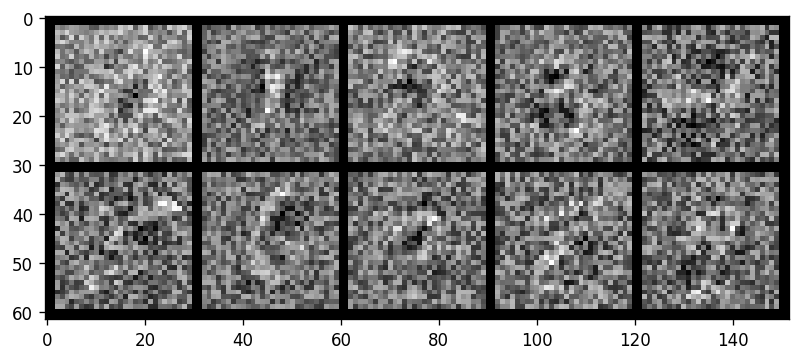

In [ ]:
# Plot the weights of the single-layer model (reduced-data version)
if (dataset == 'mnist') and (single_net2 is not None):
    plot_mnist_single_net(single_net2)

**Train a Multi-layer Network** \\

In [ ]:
class MultiLayerNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden=1000):
        super(MultiLayerNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_outputs)
        )

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.mlp(input)
        return output

# Start by initializing model and optimizer
print('\n====== init started ==========')
multi_layer_net1 = MultiLayerNet(num_inputs, num_outputs)
print(multi_layer_net1)
optimizer = optim.SGD(multi_layer_net1.parameters(), lr=lr)
print('init [MultiLayerNet] done')

# Train for 10 epochs (with default params setting)
print('\n====== training started ======')
train(multi_layer_net1, epoch=10, dataloader=train_loader)

print('\n====== testing started =======')
test(multi_layer_net1, dataloader=train_loader, set_name='Train')
test(multi_layer_net1, dataloader=test_loader, set_name='Test')


====== init started ==========
MultiLayerNet(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1000, out_features=10, bias=True)
  )
)
init [MultiLayerNet] done

====== training started ======
using cuda for training
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334387
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.682136
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.483789
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.531126
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.350050
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.458546
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.441457
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.508016
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.211583
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.281227
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.369742
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.401595
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.323738
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.267912
Train Epoch: 2 

**Set the learning rate to 10** \\
Explanation: Each step of the model is too large, so the loss ends up quite high. The model can hardly approach the minima, so its final accuracy (both train & val) is worse than the case with a properly chosen learning rate.

In [ ]:
# Start by initializing model and optimizer
print('\n====== init started ==========')
multi_layer_net2 = MultiLayerNet(num_inputs, num_outputs)
print(multi_layer_net2)
optimizer = optim.SGD(multi_layer_net2.parameters(), lr=10)
print('init [MultiLayerNet-LargeLR] done')

# Train for 10 epochs (with default params setting)
print('\n====== training started ======')
train(multi_layer_net2, epoch=10, dataloader=train_loader)

print('\n====== testing started =======')
test(multi_layer_net2, dataloader=train_loader, set_name='Train')
test(multi_layer_net2, dataloader=test_loader, set_name='Test')


====== init started ==========
MultiLayerNet(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=1000, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1000, out_features=10, bias=True)
  )
)
init [MultiLayerNet-LargeLR] done

====== training started ======
using cuda for training
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368007
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1093.787842
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1201.811401
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1291.778442
Train Epoch: 1 [25600/60000 (43%)]	Loss: 644.505615
Train Epoch: 1 [32000/60000 (53%)]	Loss: 600.343079
Train Epoch: 1 [38400/60000 (64%)]	Loss: 271.104401
Train Epoch: 1 [44800/60000 (75%)]	Loss: 504.811249
Train Epoch: 1 [51200/60000 (85%)]	Loss: 482.564392
Train Epoch: 1 [57600/60000 (96%)]	Loss: 171.824097
Train Epoch: 2 [0/60000 (0%)]	Loss: 264.940704
Train Epoch: 2 [6400/60000 (11%)]	Loss: 393.305145
Train Epoch: 2 [12800/60000 (21%)]	Loss: 260.443634
Train Epoch: 2 [19200/60000 (3

**A simple CNN on the CIFAR10 dataset**

In [ ]:
# Switch to cifar10 dataset
dataset = 'cifar10'

# Data Loading
# Warning: this cell might take some time when you run it for the first time, 
#          because it will download the datasets from the internet
if dataset == 'mnist':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

elif dataset == 'cifar10':
    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=data_transform)
    testset = datasets.CIFAR10(root='.', train=False, download=True, transform=data_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
print('Successfully initialized dataloaders for [%s].' % dataset)


Files already downloaded and verified
Files already downloaded and verified
Successfully initialized dataloaders for [cifar10].


[Images]:


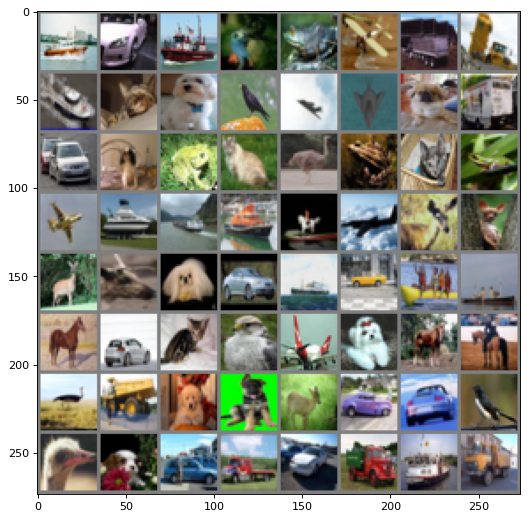

[Labels]:
tensor([[8, 1, 8, 2, 6, 0, 9, 9],
        [8, 3, 5, 2, 0, 0, 5, 9],
        [1, 5, 6, 3, 2, 6, 3, 6],
        [0, 8, 8, 8, 7, 0, 4, 5],
        [4, 4, 5, 1, 8, 1, 8, 8],
        [7, 1, 3, 2, 0, 5, 7, 7],
        [2, 9, 5, 5, 4, 1, 1, 2],
        [2, 5, 1, 9, 1, 9, 8, 9]])


In [ ]:
# get some random training images (CIFAR10)
dataiter = iter(train_loader)
images, labels = dataiter.next()
print('[Images]:')
imshow(images)
print('[Labels]:', labels.reshape(8, 8), sep='\n')

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_outputs):
        super(ConvNet, self).__init__()
        self.conv_unit = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.mlp = nn.Sequential(
            nn.Linear(in_features=3200, out_features=64),
            nn.Tanh(),
            nn.Linear(in_features=64, out_features=num_outputs),
        )

    def forward(self, input):
        b, _, _, _ = input.size()
        feats = self.conv_unit(input)
        feats = feats.view(b, -1)
        output = self.mlp(feats)
        return output

In [ ]:
# Start by initializing model and optimizer
print('\n====== init started ==========')
conv_net = ConvNet(num_outputs=10)
print(conv_net)
optimizer = optim.SGD(conv_net.parameters(), lr=lr)
print('init [ConvNet] done')

# Train for 10 epochs (with default params setting)
print('\n====== training started ======')
train(conv_net, epoch=20, dataloader=train_loader)

print('\n====== testing started =======')
test(conv_net, dataloader=train_loader, set_name='Train')
test(conv_net, dataloader=test_loader, set_name='Test')


====== init started ==========
ConvNet(
  (conv_unit): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=3200, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
init [ConvNet] done

====== training started ======
using cuda for training
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304845
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.148416
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.044633
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.954272
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.883330
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.016730
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.787620
Train Epoch: 1 [44800/500

**Plot the weights of the filters in the first-layer**

torch.Size([16, 3, 5, 5])
[Grid Size]: torch.Size([3, 16, 58])


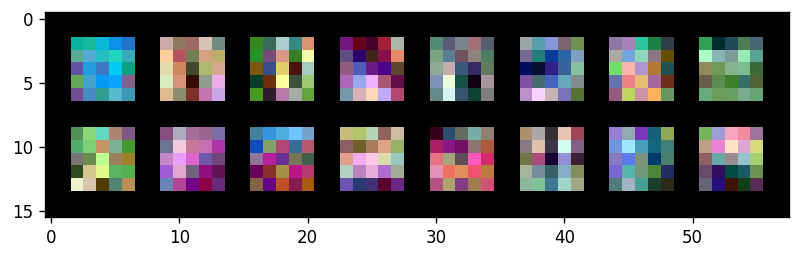

In [ ]:
from torchvision.utils import make_grid

def plot_cifar10_conv_net(network):
    print(network.conv_unit[0].weight.data.size())
    weights = network.conv_unit[0].weight.data.cpu()

    grid = make_grid(weights, nrow=8, normalize=True, scale_each=True)
    print('[Grid Size]:', grid.size())

    plt.figure(figsize=(8, 16), dpi=120)
    plt.imshow(grid.permute(1, 2, 0))

if (dataset == 'cifar10') and (conv_net is not None):
    plot_cifar10_conv_net(conv_net)

**Summary of parameters**

In [ ]:
from torchsummary import summary

print('[Single-layer Net]:')
summary(single_net1, (1, 28, 28))

print('\n[Multi-layer Net]:')
network = MultiLayerNet(num_inputs, num_outputs).to('cuda:0')
summary(multi_layer_net1, (1, 28, 28))

print('\n[Conv Net]:')
network = ConvNet(num_outputs=10).to('cuda:0')
summary(conv_net, (3, 32, 32))

[Single-layer Net]:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------

[Multi-layer Net]:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]         785,000
              Tanh-2                 [-1, 1000]               0
            Linear-3                   [-1, 10]          10,010
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
-------------------------------------------------------------